In [1]:
import os


# Check the current working directory
print("Current Working Directory:", os.getcwd())

os.chdir("/home/miguel.fernandez/ETL-Data-Science-Test/data_science/")

# Verify the change was successful
print("New Working Directory:", os.getcwd())



Current Working Directory: /home/miguel.fernandez/ETL-Data-Science-Test/data_science/notebook
New Working Directory: /home/miguel.fernandez/ETL-Data-Science-Test/data_science


# 1. Procesamiento de bases de datos

In [2]:
import pandas as pd

info_01 = pd.read_csv("data/info_01.csv")
info_02 = pd.read_csv("data/info_02.csv")

In [3]:
info_01.head()

,id,id2,v4,v5,v6
0,1,1,721.2,27.3,0.004793
1,1,1,721.2,27.3,0.004793
2,2,2,714.0,27.3,0.004783
3,2,2,714.0,27.3,0.004783
4,3,3,713.5,27.2,0.004779


In [4]:
len(info_01)

17286

In [5]:
duplicate_tuples = info_01[~info_01.duplicated(['id', 'id2'])]
print(duplicate_tuples)

         id   id2     v4    v5        v6
0         1     1  721.2  27.3  0.004793
2         2     2  714.0  27.3  0.004783
4         3     3  713.5  27.2  0.004779
6         4     4  708.2  27.2  0.004772
8         5     5  704.5  27.2  0.004757
...     ...   ...    ...   ...       ...
16276  8139  8139  787.2  36.1  0.005579
16278  8140  8140  789.5  36.0  0.005563
16280  8141  8141  798.5  36.1  0.005596
16282  8142  8142  820.3  36.3  0.005621
16284  8143  8143  821.0  36.2  0.005612

[8143 rows x 5 columns]


In [6]:
info_02.head()

,id,id2,v1,c1,v2,v3
0,1,1,426.0,1,23.2,2015-02-04 17:51:00
1,1,1,426.0,1,23.2,2015-02-04 17:51:00
2,2,2,429.5,1,23.1,2015-02-04 17:51:59
3,2,2,429.5,1,23.1,2015-02-04 17:51:59
4,3,3,426.0,1,23.1,2015-02-04 17:53:00


In [7]:
len(info_02)

17286

In [8]:
info_01_filtered = info_01[~info_01.duplicated(['id', 'id2', 'v4', 'v5', 'v6'], keep='first')]
len(info_01_filtered)


8143

In [9]:
info_02_filtered = info_02[~info_02.duplicated(['id', 'id2', 'v1', 'v2', 'v3', 'c1'], keep='first')]
len(info_02_filtered)

9143

In [10]:
info = info_02_filtered.set_index(['id', 'id2']).join(info_01_filtered.set_index(['id', 'id2']), how="inner")
info

,,v1,c1,v2,v3,v4,v5,v6
id,id2,,,,,,,
1,1,426.0,1,23.2,2015-02-04 17:51:00,721.2,27.3,0.004793
2,2,429.5,1,23.1,2015-02-04 17:51:59,714.0,27.3,0.004783
3,3,426.0,1,23.1,2015-02-04 17:53:00,713.5,27.2,0.004779
4,4,426.0,1,23.1,2015-02-04 17:54:00,708.2,27.2,0.004772
5,5,426.0,1,23.1,2015-02-04 17:55:00,704.5,27.2,0.004757
...,...,...,...,...,...,...,...,...
5411,5411,65.7,0,19.2,NaN,423.3,30.8,0.004235
6547,6547,0.0,0,19.3,NaN,463.0,26.1,0.003606
1806,1806,0.0,0,20.2,NaN,445.0,21.2,0.003104


In [11]:
for i in range(1, 7):
    print(f"Null values in v{i}: {int(info[f'v{i}'].isna().sum())}")

Null values in v1: 0
Null values in v2: 0
Null values in v3: 1000
Null values in v4: 0
Null values in v5: 0
Null values in v6: 0


## 1.1 Conversión de fecha a variable numérica

### 1.1.1 Fecha a segundos desde primer registro

In [12]:
def converter(date):
    stamp = pd.date_range(date, periods=4, freq="D")
    stamp = stamp - info["v3"].min() // pd.Timedelta("1s")
    return stamp

date_ranges = info["v3"].apply(lambda x: pd.Timestamp(x) if x is not None else None)
reference = date_ranges.min()
info["v3_num"] = date_ranges.apply(lambda x: (x - reference).total_seconds() if x is not None else None)



In [13]:
import numpy as np

# Convertir columna de fecha a valores periódicos basados en los segundos transcurridos en el día
# Esto es útil para capturar la naturaleza cíclica del tiempo con mayor granularidad

# 1. Primero convierte a datetime
info['timestamp_datetime'] = pd.to_datetime(info['v3'])

# 2. Extrae las componentes de tiempo
info['hour'] = info['timestamp_datetime'].dt.hour
info['minute'] = info['timestamp_datetime'].dt.minute
info['second'] = info['timestamp_datetime'].dt.second

# 3. Calcula los segundos transcurridos desde medianoche (0-86399)
info['seconds_of_day'] = info['hour'] * 3600 + info['minute'] * 60 + info['second']

# 4. Convierte los segundos a valores periódicos usando seno y coseno
# Esto captura que 23:59:59 está cerca de 0:00:00
info['seconds_sin'] = np.sin(2 * np.pi * info['seconds_of_day'] / 86400)
info['seconds_cos'] = np.cos(2 * np.pi * info['seconds_of_day'] / 86400)

print(info[['v3', 'seconds_of_day', 'seconds_sin', 'seconds_cos']].head())


                         v3  seconds_of_day  seconds_sin  seconds_cos
id id2                                                               
1  1    2015-02-04 17:51:00         64260.0    -0.999229    -0.039260
2  2    2015-02-04 17:51:59         64319.0    -0.999388    -0.034972
3  3    2015-02-04 17:53:00         64380.0    -0.999534    -0.030539
4  4    2015-02-04 17:54:00         64440.0    -0.999657    -0.026177
5  5    2015-02-04 17:55:00         64500.0    -0.999762    -0.021815


### 1.1.2 Filtro de datos nulos

In [ ]:
info_filtered = info[~info['v3'].isna()].reset_index()

### 1.1.3 Proporción de clases

In [15]:
print(" info: ", info["c1"].sum() / len(info))
print(" info_filtered: ", info_filtered["c1"].sum() / len(info_filtered))

 info:  0.211090451711692
 info_filtered:  0.2123296082524868


# 2. Análisis estadístico

## 2.1 Análisis de correlación


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = info[['v1', 'v2', 'v4', 'v5', 'v6', 'seconds_sin', 'seconds_cos', 'seconds_of_day']].corr()

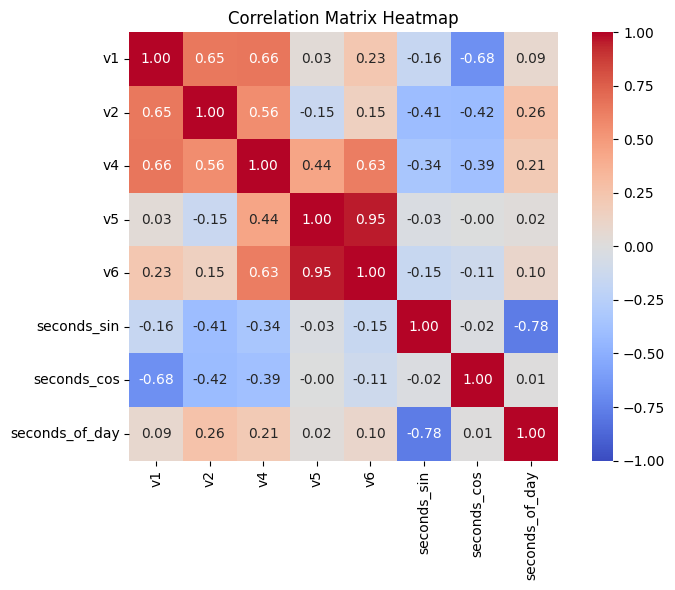

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.2f', 
            cmap='coolwarm',
            center=0,
            square=True,
            vmin=-1, vmax=1)  # Fixed range for correlation
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
g = sns.pairplot(info[['v1', 'v2', 'v4', 'v5', 'v6', 'seconds_sin', 'seconds_cos', 'seconds_of_day', 'c1']], 
                 hue='c1',  # Color by category
                 diag_kind='hist',
                 palette='viridis',
                 plot_kws={'alpha': 0.7, 's': 50})
plt.show()

KeyboardInterrupt: 

## 2.2 Feature selection

In [43]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_names = ['v1', 'v2', 'v4', 'v5', 'v6', 'seconds_sin', 'seconds_cos', 'seconds_of_day']
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(info_filtered[feature_names], info_filtered['c1'])

# See which features are most discriminative
scores = selector.scores_
for name, score in zip(feature_names, scores):
    print(f"{name}: {score:.3f}")

v1: 37928.320
v2: 3312.339
v4: 8381.539
v5: 146.309
v6: 806.816
seconds_sin: 172.850
seconds_cos: 3322.118
seconds_of_day: 52.700


# 3. Modelo para clustering

## 3.1 Ajuste de mezclas gaussianas con reducción de dimensionalidad (PCA 2 componentes)

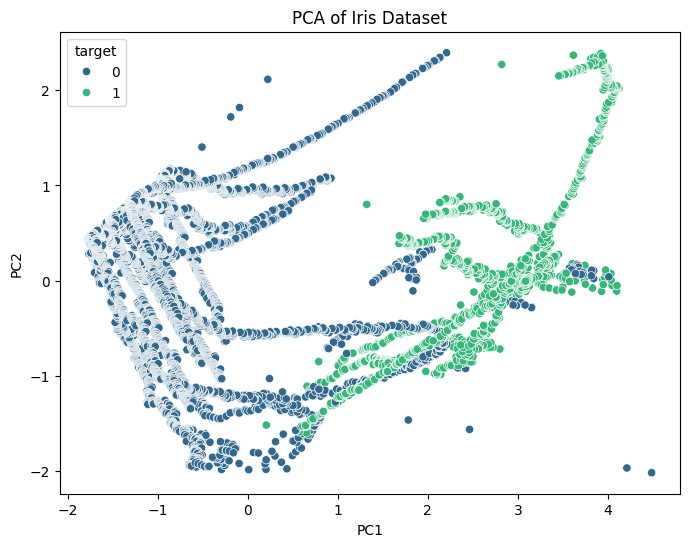

In [44]:
X = info_filtered[['v1', 'v2', 'v4', 'seconds_cos']].to_numpy()
y = info_filtered['c1'].to_numpy()

X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['target'] = y  # Use the target labels for coloring

# Visualize with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', palette='viridis')
plt.title('PCA of Iris Dataset')
plt.show()

In [46]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix

from scipy.stats import mode

X = info_filtered[['v1', 'v2', 'v4', 'seconds_cos']].to_numpy()
y = info_filtered['c1'].to_numpy()

X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


gmm = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=40
)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)
probs = gmm.predict_proba(X_pca)


# Map predicted cluster to true labels
mapping = {}
for cluster in np.unique(labels):
    mask = labels == cluster
    mapping[cluster] = mode(y[mask], keepdims=False).mode

# Apply mapping
y_pred = np.array([mapping[label] for label in labels])

print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred, digits=3))


Confusion Matrix:
[[5692  722]
 [   0 1729]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.887     0.940      6414
           1      0.705     1.000     0.827      1729

    accuracy                          0.911      8143
   macro avg      0.853     0.944     0.884      8143
weighted avg      0.937     0.911     0.916      8143



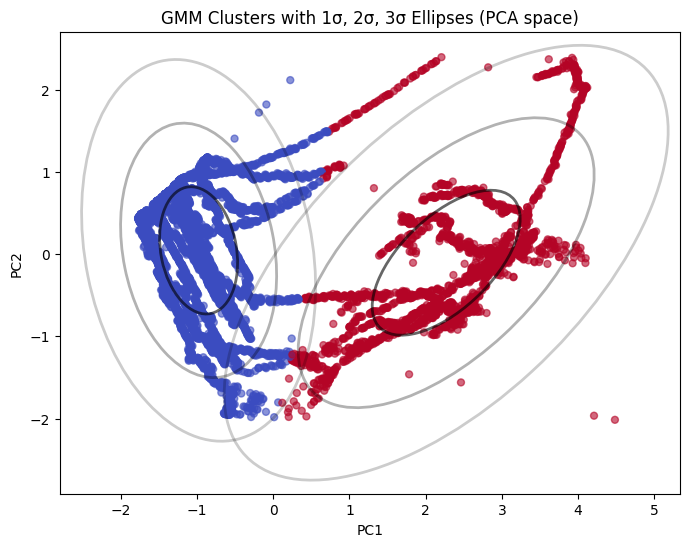

In [47]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt

def plot_gmm_ellipses(gmm, X, labels, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter points by predicted labels
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', s=25, alpha=0.6)
    ax.set_title("GMM Clusters with 1σ, 2σ, 3σ Ellipses (PCA space)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    # Function to draw confidence ellipses
    def draw_confidence_ellipses(position, covariance, ax, n_std_list=[1, 2, 3], **kwargs):
        """Draw ellipses for multiple confidence intervals (1σ, 2σ, 3σ)."""
        if covariance.shape == (2, 2):
            vals, vecs = np.linalg.eigh(covariance)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

            # Draw one ellipse per sigma level
            for n_std in n_std_list:
                width, height = 2 * n_std * np.sqrt(vals)
                ell = Ellipse(
                    xy=position,
                    width=width,
                    height=height,
                    angle=theta,
                    edgecolor='black',
                    facecolor='none',
                    lw=2,
                    alpha=0.6 / n_std,  # lighter for larger sigma
                    **kwargs
                )
                ax.add_patch(ell)

    # Plot each Gaussian component
    for mean, cov in zip(gmm.means_, gmm.covariances_):
        draw_confidence_ellipses(mean, cov, ax)

    plt.show()


plot_gmm_ellipses(gmm, X_pca, y_pred)

## 3.2 Ajuste de mezclas gaussianas

In [76]:
X = info_filtered[['v1', 'v2', 'v4', 'seconds_cos']].to_numpy()
y = info_filtered['c1'].to_numpy()


gmm = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=40
)
gmm.fit(X)
labels = gmm.predict(X)
probs = gmm.predict_proba(X)


# Map predicted cluster to true labels
mapping = {}
for cluster in np.unique(labels):
    mask = labels == cluster
    mapping[cluster] = mode(y[mask], keepdims=False).mode

# Apply mapping
y_pred = np.array([mapping[label] for label in labels])

print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred, digits=3))


Confusion Matrix:
[[4936 1478]
 [   0 1729]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.770     0.870      6414
           1      0.539     1.000     0.701      1729

    accuracy                          0.818      8143
   macro avg      0.770     0.885     0.785      8143
weighted avg      0.902     0.818     0.834      8143



### 3.2.1 Imputación de fechas nulas

In [77]:
import numpy as np
from scipy.stats import multivariate_normal

def gmm_impute_column(gmm, X, target_col):
    """
    Fill missing values in target_col using a trained GaussianMixture model.

    Parameters
    ----------
    gmm : sklearn.mixture.GaussianMixture
        Trained GMM model.
    X : np.ndarray
        Data array of shape (n_samples, n_features).
    target_col : int
        Index of the column to impute.

    Returns
    -------
    X_filled : np.ndarray
        Copy of X with imputed values in the target column.
    """
    X_filled = X.copy()
    n_samples, n_features = X.shape

    for i in range(n_samples):
        if np.isnan(X[i, target_col]):
            obs_idx = np.where(~np.isnan(X[i]))[0]
            miss_idx = np.array([target_col])

            x_obs = X[i, obs_idx]

            # Compute responsibilities p(z=k | x_obs)
            probs = []
            cond_means = []
            for k in range(gmm.n_components):
                mu_k = gmm.means_[k]
                Sigma_k = gmm.covariances_[k]

                # Extract observed/missing parts
                mu_obs = mu_k[obs_idx]
                mu_miss = mu_k[miss_idx]

                Sigma_oo = Sigma_k[np.ix_(obs_idx, obs_idx)]
                Sigma_mo = Sigma_k[np.ix_(miss_idx, obs_idx)]
                Sigma_oo_inv = np.linalg.inv(Sigma_oo)

                # Likelihood of observed data under this component
                p_xobs_given_k = multivariate_normal.pdf(x_obs, mean=mu_obs, cov=Sigma_oo)
                probs.append(gmm.weights_[k] * p_xobs_given_k)

                # Conditional mean
                cond_mean = mu_miss + Sigma_mo @ Sigma_oo_inv @ (x_obs - mu_obs)
                cond_means.append(cond_mean.item())

            probs = np.array(probs)
            if probs.sum() == 0:
                # fallback if all probabilities are numerically zero
                probs = np.ones_like(probs)
            probs /= probs.sum()

            # Weighted average of conditional means
            X_filled[i, target_col] = np.dot(probs, cond_means)

    return X_filled


In [79]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import numpy as np

# Create synthetic data
X = info[['v1', 'v2', 'v4', 'seconds_cos']].to_numpy()
y = info['c1'].to_numpy()


# Impute
X_filled = gmm_impute_column(gmm, X, target_col=3)

info_filled = pd.DataFrame(X_filled, columns=['v1', 'v2', 'v4', 'seconds_cos'])
info_filled['c1'] = y

In [80]:
info_filled.tail()

,v1,v2,v4,seconds_cos,c1
9138,65.7,19.2,423.3,-0.608326,0
9139,0.0,19.3,463.0,0.419987,0
9140,0.0,20.2,445.0,0.504193,0
9141,58.8,20.1,420.2,-0.584409,0
9142,0.0,19.6,449.0,0.451867,0


# 4. Clasificador regresión lógistica v.1

0.017749309539794922
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1276
           1       0.94      0.99      0.96       353

    accuracy                           0.98      1629
   macro avg       0.97      0.99      0.98      1629
weighted avg       0.98      0.98      0.98      1629



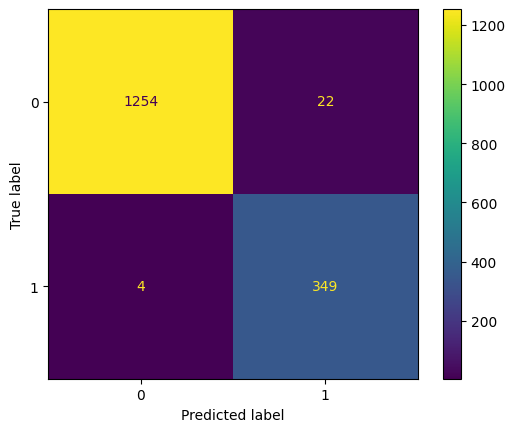

Intercept (bias): 0.415
Coefficient for feature v1: 0.024
Coefficient for feature v2: -0.503
Coefficient for feature v4: 0.004
Coefficient for feature seconds_cos: 1.989


In [63]:
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature_names = ["v1", "v2", "v4", "seconds_cos"]

X = info_filtered[feature_names].to_numpy()
y = info_filtered["c1"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    max_iter=1000
)

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_pred = model.predict(X_test)

print(end_time - start_time)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

cm_display.plot()

plt.show()



# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# For a binary classification problem, you can access the values directly
print(f"Intercept (bias): {intercept[0]:.3f}")
for label, coef in zip(feature_names, coefficients[0]):
    print(f"Coefficient for feature {label}: {coef:.3f}")



#  4.2 Clasificador regresión lógistica + imputación de fechas nulas

0.021152496337890625
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1450
           1       0.95      1.00      0.97       379

    accuracy                           0.99      1829
   macro avg       0.98      0.99      0.98      1829
weighted avg       0.99      0.99      0.99      1829



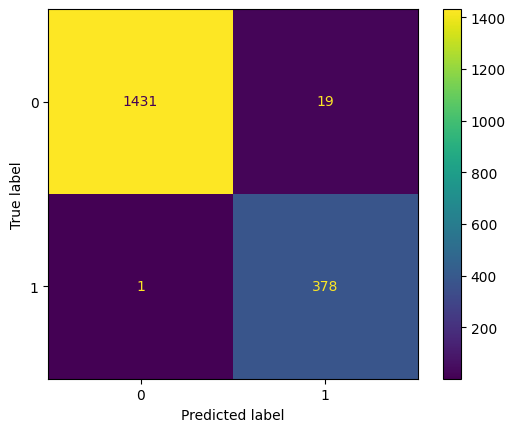

Intercept (bias): 0.325
Coefficient for feature v1: 0.022
Coefficient for feature v2: -0.483
Coefficient for feature v4: 0.005
Coefficient for feature seconds_cos: 1.450


In [89]:
feature_names = ["v1", "v2", "v4", "seconds_cos"]

X = info_filled[feature_names].to_numpy()
y = info_filled["c1"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

model = LogisticRegression(
    penalty='l2',
    C=5,
    solver='liblinear',
    max_iter=1000
)

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

y_pred = model.predict(X_test)

print(end_time - start_time)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

cm_display.plot()

plt.show()



# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# For a binary classification problem, you can access the values directly
print(f"Intercept (bias): {intercept[0]:.3f}")
for label, coef in zip(feature_names, coefficients[0]):
    print(f"Coefficient for feature {label}: {coef:.3f}")# Train GMM

# Clasificador regresión lógistica v.2

In [ ]:
# Create figure and axes with more control
fig, axes = plt.subplots(figsize=(10, 20), ncols=1, nrows=5)

# Reset index to make columns accessible and ensure proper data types
info_filtered = info[~info['v3'].isna()].reset_index().copy()
# Ensure v3 is datetime
info_filtered['v3'] = pd.to_datetime(info_filtered['v3'])

# Plot with different styles
for e, label in enumerate('v1,v2,v4,v5,v6'.split(',')):
        axes[e].plot(info_filtered['v3'], info_filtered[label], 
                label=label,  
                linewidth=2.5, 
                marker='o', 
                markersize=4)
        axes[e].legend()
        
plt.tight_layout()
plt.show()

Error in callback <function _draw_all_if_interactive at 0x7effa56e6de0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
def converter(date):
    stamp = pd.date_range(date, periods=4, freq="D")
    stamp = stamp - info_filtered["v3"].min() // pd.Timedelta("1s")
    return stamp

date_ranges = info_filtered["v3"].apply(lambda x: pd.Timestamp(x))
reference = date_ranges.min()
# Create a copy to avoid SettingWithCopyWarning
info_filtered = info_filtered.copy()
info_filtered["v3_num"] = date_ranges.apply(lambda x: (x - reference).total_seconds())

/tmp/ipykernel_892228/1330408671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_filtered["v3_num"] = date_ranges.apply(lambda x: (x - reference).total_seconds())


In [70]:
info_filtered["v3_num"]

id    id2 
1     1            0.0
2     2           59.0
3     3          120.0
4     4          180.0
5     5          240.0
                ...   
8139  8139    488280.0
8140  8140    488339.0
8141  8141    488399.0
8142  8142    488460.0
8143  8143    488520.0
Name: v3_num, Length: 8143, dtype: float64

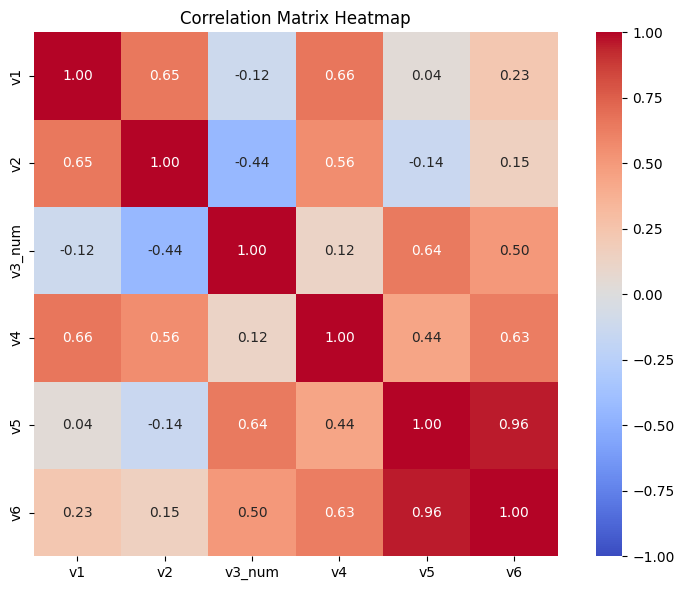

In [71]:
corr_matrix = info_filtered[['v1', 'v2', 'v3_num', 'v4', 'v5', 'v6']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.2f', 
            cmap='coolwarm',
            center=0,
            square=True,
            vmin=-1, vmax=1)  # Fixed range for correlation
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

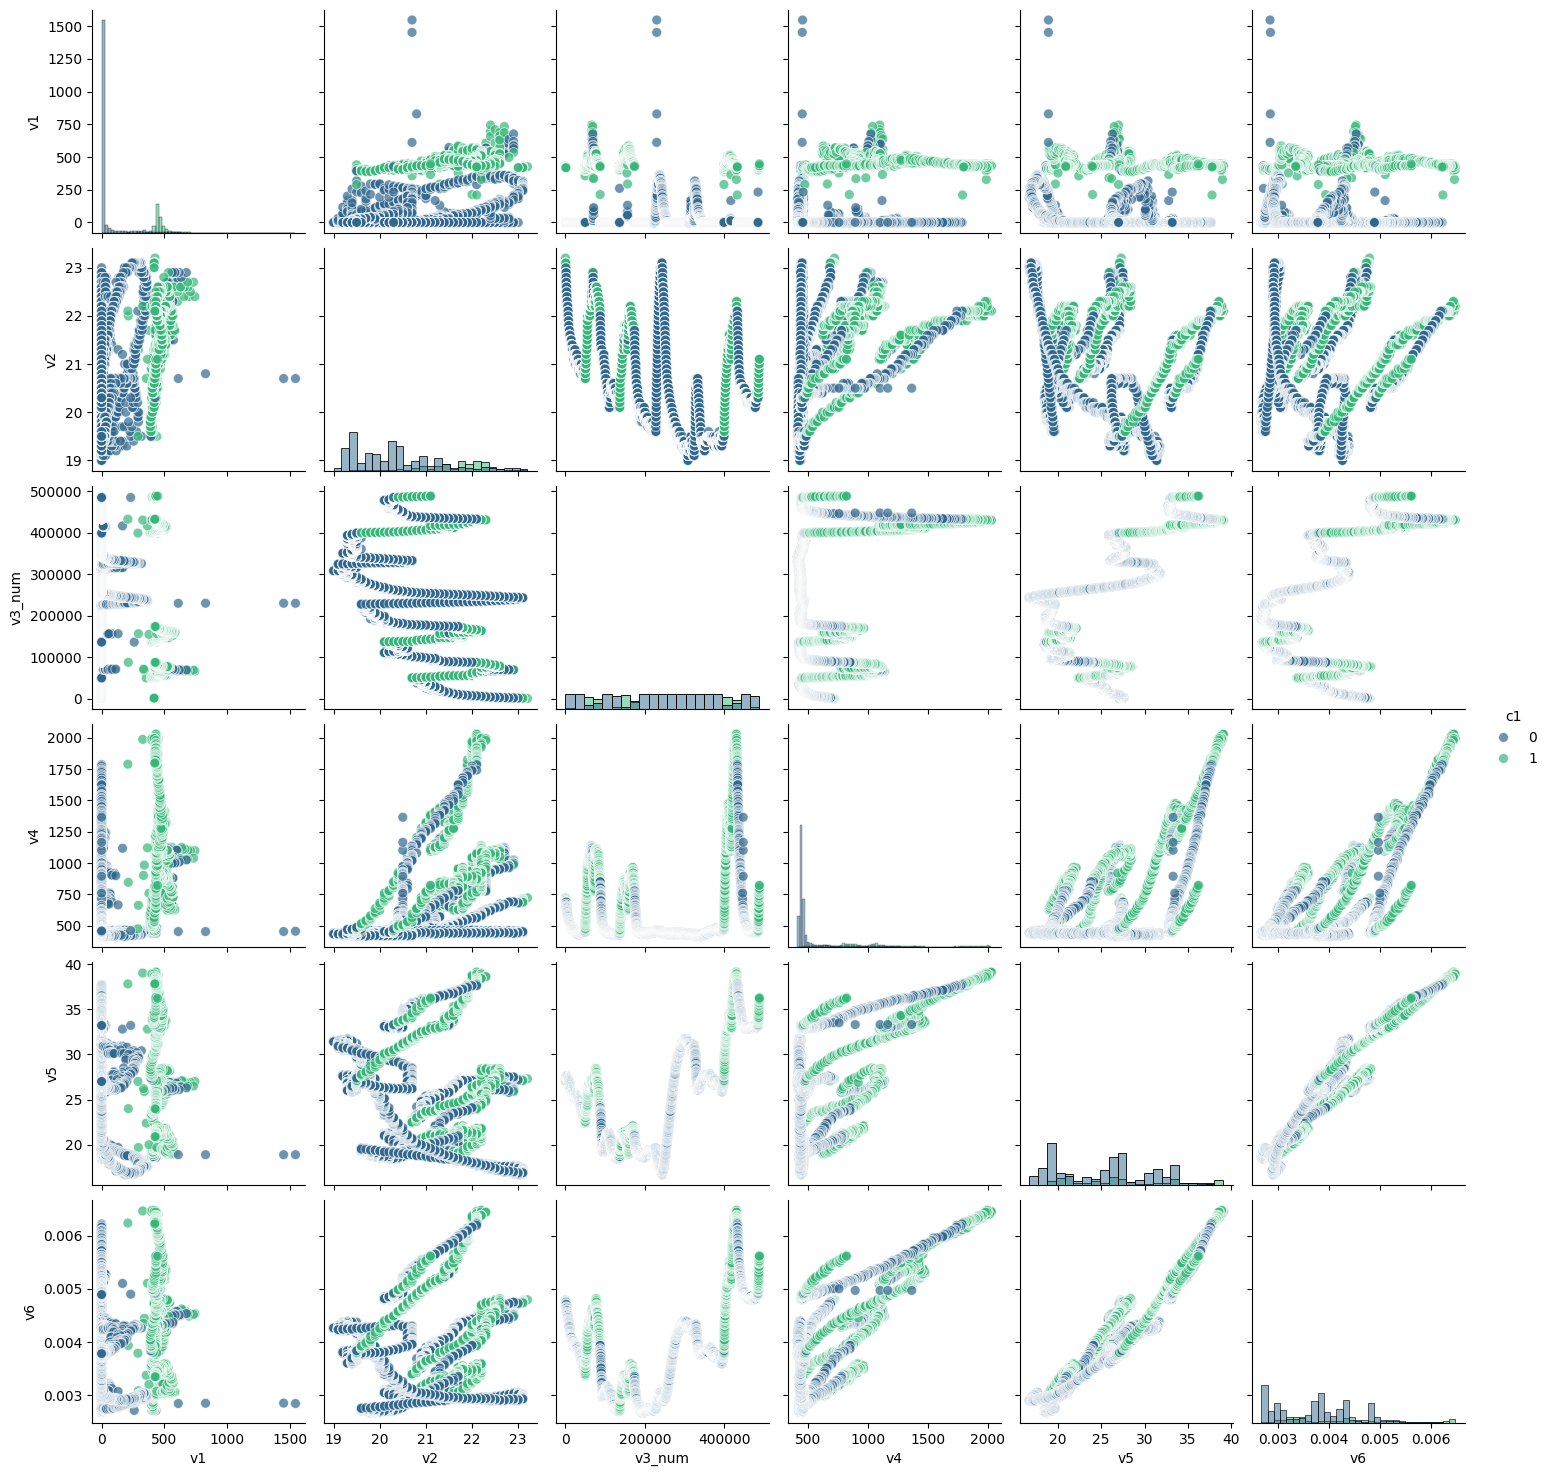

In [73]:
g = sns.pairplot(info_filtered[['v1', 'v2', 'v3_num', 'v4', 'v5', 'v6', 'c1']], 
                 hue='c1',  # Color by category
                 diag_kind='hist',
                 palette='viridis',
                 plot_kws={'alpha': 0.7, 's': 50})
plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = info_filtered["v1,v2,v4,v3_num,v5,v6".split(',')].to_numpy()
y = info_filtered[["c1"]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    max_iter=1000
)

In [75]:
import time 

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

print(end_time - start_time)

0.039209842681884766


/home/miguel.fernandez/.conda/envs/env-etl/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1276
           1       0.86      0.97      0.91       353

    accuracy                           0.96      1629
   macro avg       0.92      0.96      0.94      1629
weighted avg       0.96      0.96      0.96      1629



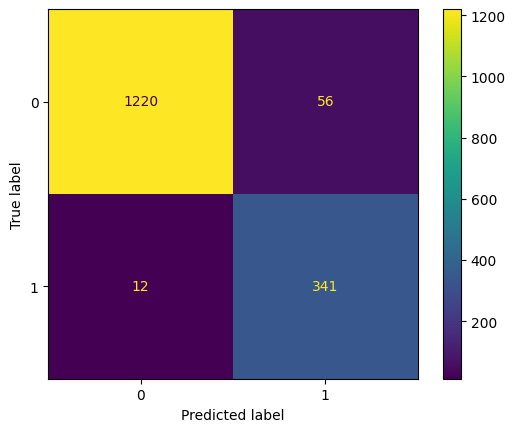

In [77]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

cm_display.plot()

plt.show()